In [1]:
from sklearn.mixture import GMM
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn

from sklearn.metrics import accuracy_score

%matplotlib inline

# Create dataset`s

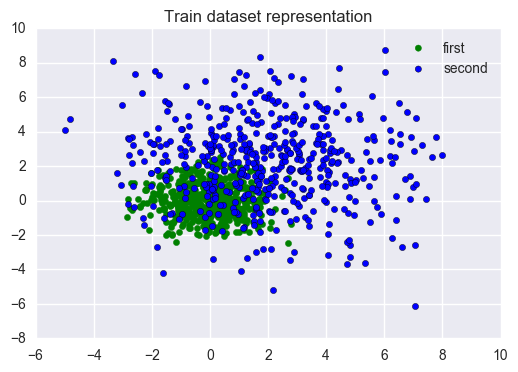

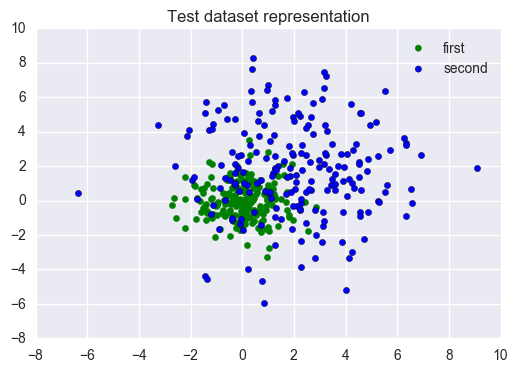

In [2]:
v = 2
middle_f = (0,0)
cov_matrix_f = np.array(([v / 2, 0 ], [0, v/2]))

firstSet =  np.random.multivariate_normal(middle_f, cov_matrix_f, 500)
firstSetTest =  np.random.multivariate_normal(middle_f, cov_matrix_f, 200)


middle_s = (v, v)
cov_matrix_s = np.array(([3*v, 0 ], [0, 3*v]))

secondSet = np.random.multivariate_normal(middle_s, cov_matrix_s, 500)
secondSetTest = np.random.multivariate_normal(middle_s, cov_matrix_s, 200)

x_train = np.concatenate((firstSet, secondSet))
y_train = np.concatenate([np.zeros((500)), np.ones((500))]).astype('int')

x_test = np.concatenate( [ firstSetTest, secondSetTest] )
y_test = np.concatenate([np.zeros((200)), np.ones((200))]).astype('int')


plt.title('Train dataset representation')
plt.scatter(firstSet[:, 0],  firstSet[:, 1],color = 'green', label = 'first')
plt.scatter(secondSet[:, 0],  secondSet[:, 1], label = 'second')
plt.legend()
plt.show()


plt.title('Test dataset representation')
plt.scatter(firstSetTest[:, 0],  firstSetTest[:, 1],color = 'green', label = 'first')
plt.scatter(secondSetTest[:, 0],  secondSetTest[:, 1], label = 'second')
plt.legend()
plt.show()

In [63]:
covar_type = 'diag'
i = 2

g1 =  GMM(n_components = i, covariance_type='full', init_params='wmc', n_iter=100)
g1.fit(firstSet)
g2 =  GMM(n_components = i, covariance_type=covar_type, init_params='wmc', n_iter=100)
g2.fit(secondSet)

prediction  = np.array(np.log(firstSet.shape[0])+ g1.score(x_test)  < np.log(secondSet.shape[0])+g2.score(x_test)).astype('int')

accuracy = np.mean(prediction == y_test) * 100
print 'gaussian kernels = %d, accuracy = %f'%(i, accuracy)

gaussian kernels = 2, accuracy = 86.000000


In [13]:
np.asarray(g1.score_samples(firstSet)[1]).shape

(500L, 2L)

In [14]:
g1.weights_.shape

(2L,)

In [15]:
g1.means_.shape

(2L, 2L)

In [64]:
g1.covars_.shape

(2L, 2L, 2L)

# Create MAP-adaptaion for ubm model

In [67]:
def computeUBM(ubm_model, data):
    
    xdim = data.shape[1]
    
    ###############################################################   
    #    ubm_means: means of the ubm <number array>               #
    #    ubm_covars: covariances of the ubm <number array>        #
    #    ubm_weights: weights of the ubm <number array>           #
    #    new_means: means adapted from the ubm <number array>     #
    #    new_weights: weights adapted from the ubm <number array> #
    ###############################################################    
        
    # Copy parameters our GMM-model
    ubm_weights = ubm_model.weights_
    ubm_means = ubm_model.means_
    ubm_covars = ubm_model.covars_

    M = ubm_model.n_components 
    
    ###################################################################
    # for X = {x_1, ..., x_T}                                         # 
    # P(i|x_t) = w_i * p_i(x_t) / sum_j=1_M(w_j * P_j(x_t))           #
    ###################################################################
    
    posterior_prob = ubm_model.predict_proba(data)
    pr_i_xt = (ubm_weights * posterior_prob)/ np.asmatrix(np.sum(ubm_weights \
                                                * posterior_prob, axis = 1)).T

    n_i = np.asarray(np.sum(pr_i_xt, axis = 0)).flatten() # [M, ]
    
    # Then we can compute E(x) and E(x2) and calculate new parameters of
    # our model
    
    
    E_x = np.asarray([(np.asarray(pr_i_xt[:, i]) * data).sum(axis = 0) / n_i[i] for i in range(M)]) # [M x xdim]
    
    E_x2 = np.asarray([(np.asarray(pr_i_xt[:, i]) * (data ** 2)).sum(axis = 0) / n_i[i] for i in range(M)])# [M x xdim]

    ################################################################ 
    #    T: scaling factor, number of samples                      #
    #    relevance_factor: factor for scaling the adapted means    #
    #    scaleparam - scale parameter for weights matrix estimation#
    ################################################################  
    
    T = data.shape[0]   
    relevance_factor = 16
    scaleparam = 1
    
    ################################################################      
    # compute alpha_i: data-depentend apaptation coefficient       #
    # alpha_w = alpha_m = alpha_v                                  #
    # alpha_i = n_i/ (n_i + relevance factor)                      #
    ################################################################

    
    alpha_i = n_i / (n_i + relevance_factor)

    ###############################
    # Parqameter`s adaptation
    ##############################
    
    new_weights = (alpha_i * n_i / T + (1.0 - alpha_i)* ubm_weights) * scaleparam
    
    
    alpha_i = np.asarray(np.asmatrix(alpha_i).T)

    
    new_means = (alpha_i * E_x + (1. - alpha_i) * ubm_means)

    #print alpha_i.shape
    #print (E_x2).shape
    #print ubm_covars.shape
    #print new_means.shape
    
    #print (1. - alpha_i) * (ubm_covars + np.dot(ubm_means, ubm_means.T))

    #new_covars = alpha_i * E_x2 + (1. - alpha_i) * (ubm_covars + (ubm_means **2))# - (new_means ** 2)
    new_covars = alpha_i * E_x2 + (1. - alpha_i) * (ubm_model.covars_ + ubm_model.means_ **2) - new_means ** 2
    ubm_model.means_ = new_means
    ubm_model.weights_ = new_weights
    #ubm_model.covars_ = new_covars

    return ubm_model


g1 = GMM(n_components=4, covariance_type='full')
g1.fit(firstSet)

re = computeUBM(g1, firstSet)

(4L, 2L)


ValueError: operands could not be broadcast together with shapes (4,2,2) (4,2) 

In [62]:
print g1.covars_.shape

(4L, 2L, 2L)
